In [137]:
import glob
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

from loveisland.common.constants import MALE, PALETTE, RELEVANT_ISLANDERS, ISLANDERS
from loveisland.common.functions import import_all

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use("bmh")

In [134]:
def islander_agg(df, islander):
    """Aggregate various metrics per islander/date"""
    AGG_JS = {
        "favs": "mean",
        "retwe": "mean",
        "score": "mean",
        "user": "nunique",
        "url": "count",
        "weight_senti": "mean",
    }
    RN_JS = {islander: "islander", "url": "n_tweets", "user": "n_users"}
    df = df[df[islander] == islander]
    if len(df) > 0:
        return df.groupby([islander, "date"])\
                 .agg(AGG_JS)\
                 .reset_index()\
                 .rename(columns=RN_JS)
    return pd.DataFrame()

def aggregate_all(df):
    """Loop over all islanders, aggregating metrics"""
    agg_df = pd.DataFrame()
    for islander in ISLANDERS:
        agg = islander_agg(df, islander)
        agg_df = agg_df.append(agg, sort=True)
    return agg_df.reset_index(drop=True)

def apply_filters(df):
    return df[(df["n_tweets"] >= 100) & (df["islander"].isin(RELEVANT_ISLANDERS))]

def add_cols(df):
    df["total_favs"] = df["favs"] * df["n_tweets"]
    df["total_retwe"] = df["retwe"] * df["n_tweets"]
    df["sex"] = df["islander"].apply(lambda x: "male" if x in MALE else "female")
    return df

In [50]:
df = import_all()
df = df[df["date"] >= "2019-06-03"]
agg_df = aggregate_all(df)

agg_df = apply_filters(agg_df)
agg_df = add_cols(agg_df)
agg_df.head()

/Users/samwatson/projects/loveisland/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,date,favs,islander,n_tweets,n_users,retwe,score,weight_senti,total_favs,total_retwe,sex
0,2019-06-03,46.807939,anton,9825,7447,6.354606,-0.040006,2.440821,459888.0,62434.0,male
1,2019-06-04,50.156853,anton,2021,1781,6.782286,0.013526,3.541229,101367.0,13707.0,male
2,2019-06-05,15.604717,anton,1060,959,1.413208,0.038717,1.714590,16541.0,1498.0,male
3,2019-06-06,27.159757,anton,2967,2448,2.827772,0.094877,2.486267,80583.0,8390.0,male
4,2019-06-07,73.279510,anton,3592,2954,8.333797,0.135504,9.704618,263220.0,29935.0,male


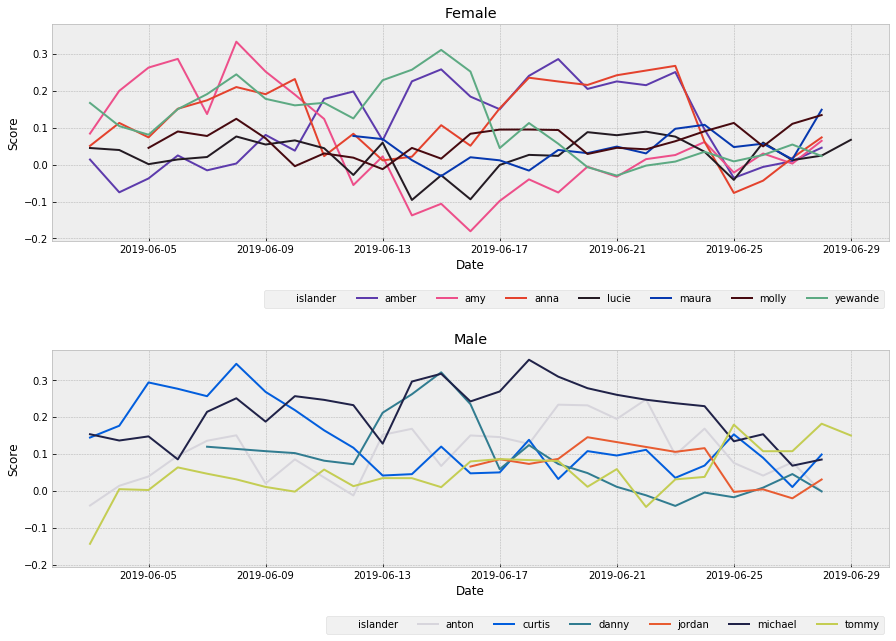

In [52]:
def add_meta(ax, metric, title, x="Date"):
    ax.legend(bbox_to_anchor=(1, -0.2), ncol=11)
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(metric)

args = {"x": "date", "y": "score", "hue": "islander", "palette": PALETTE}
    
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(data=agg_df[agg_df["sex"]=="female"], ax=ax1, **args)
add_meta(ax1, "Score", "Female")

ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1)
sns.lineplot(data=agg_df[agg_df["sex"]=="male"], ax=ax2, **args)
add_meta(ax2, "Score", "Male")

plt.subplots_adjust(hspace=0.5);

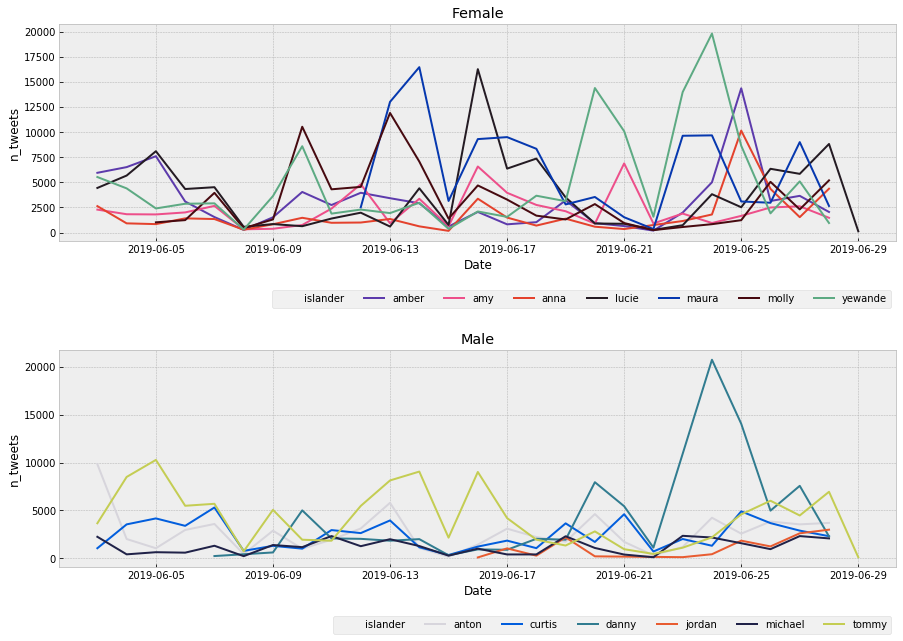

In [54]:
args = {"x": "date", "y": "n_tweets", "hue": "islander", "palette": PALETTE}
    
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
sns.lineplot(data=agg_df[agg_df["sex"]=="female"], ax=ax1, **args)
ax1 = add_meta(ax1, "n_tweets", "Female")

ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1)
sns.lineplot(data=agg_df[agg_df["sex"]=="male"], ax=ax2, **args)
ax2 = add_meta(ax2, "n_tweets", "Male")

plt.subplots_adjust(hspace=0.5);

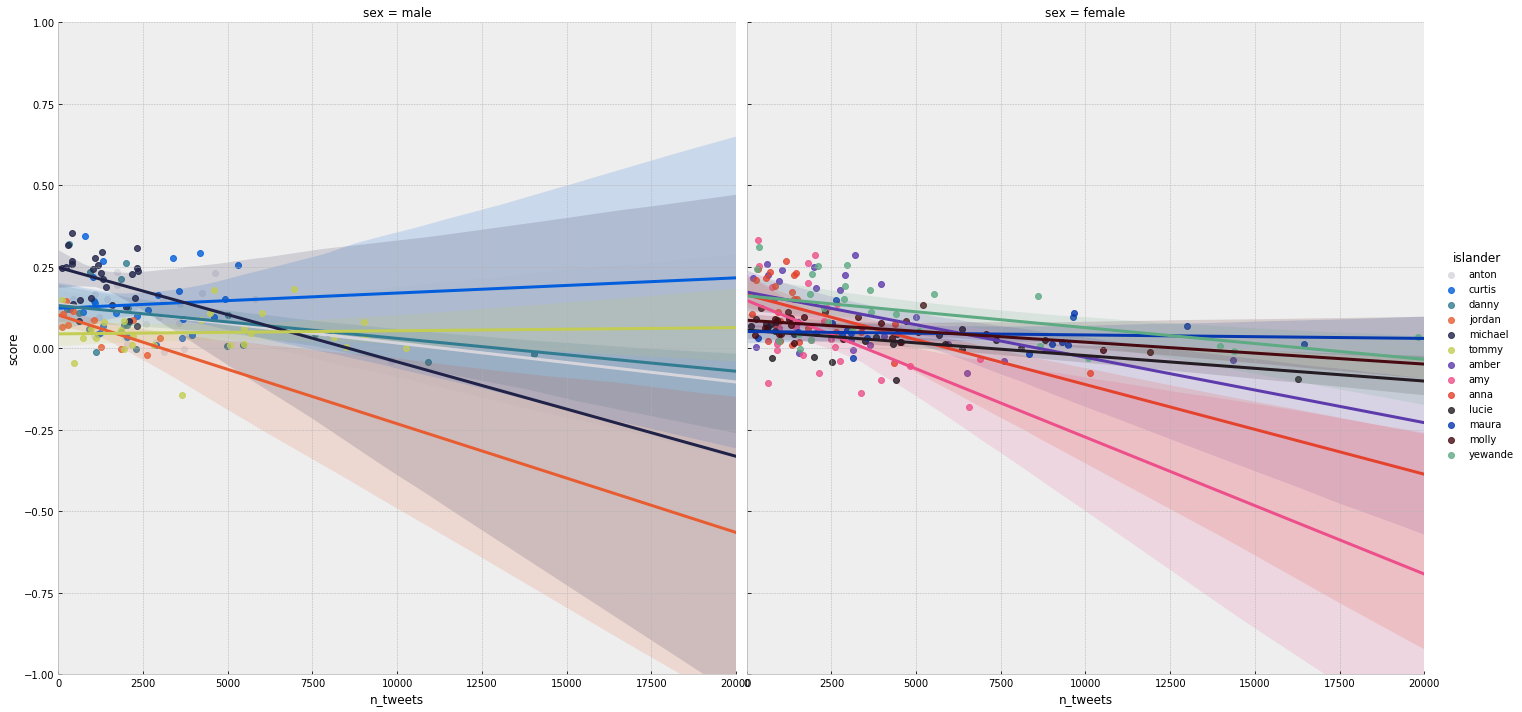

In [55]:
# Who is the most controversial?
# More tweets being correlated with a negative score = more convtroversial??

sns.lmplot("n_tweets", "score", hue="islander", data=agg_df, palette=PALETTE, height=10, col="sex")
plt.ylim(-1,1)
plt.xlim(0,20000);

In [56]:
def get_counts(df, group):
    return df.groupby(group)["url"].count().reset_index(name="count")

def order_days(df, col="dotw"):
    df[col] = pd.Categorical(
                df[col],
                categories=[
                    "Monday",
                    "Tuesday",
                    "Wednesday",
                    "Thursday",
                    "Friday",
                    "Saturday",
                    "Sunday",
                ],
                ordered=True,
            )
    return df

def get_daily_counts(df, col="date"):
    df = get_counts(df, [col])
    df["dotw"] = df[col].dt.strftime("%A")
    return order_days(df)


def format_xticks(df, ax, n=1, col="date", rotate=True):
    x_dates = to_plot["date"].dt.strftime('%Y-%m-%d').sort_values().unique()
    ax.xaxis.set_major_formatter(plt.FixedFormatter(x_dates))

    if rotate:
        plt.xticks(rotation=20, ha="right")
    
    xticks = ax.xaxis.get_major_ticks()
    for i in range(len(xticks)):
        if i % n != 0:
            xticks[i].set_visible(False);

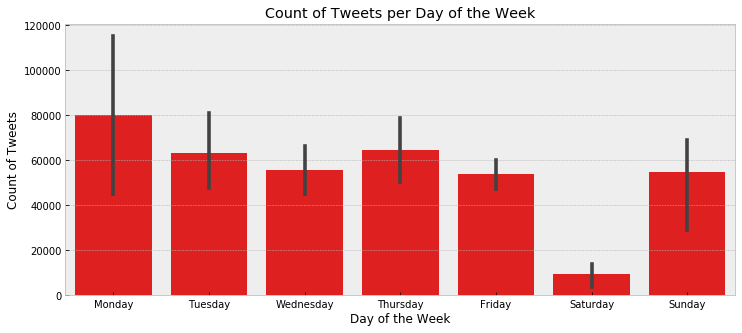

In [57]:
to_plot = get_daily_counts(df) 

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("dotw", "count", data=to_plot, color="Red", ax=ax1)

plt.xlabel("Day of the Week")
plt.ylabel("Count of Tweets")
plt.title("Count of Tweets per Day of the Week");

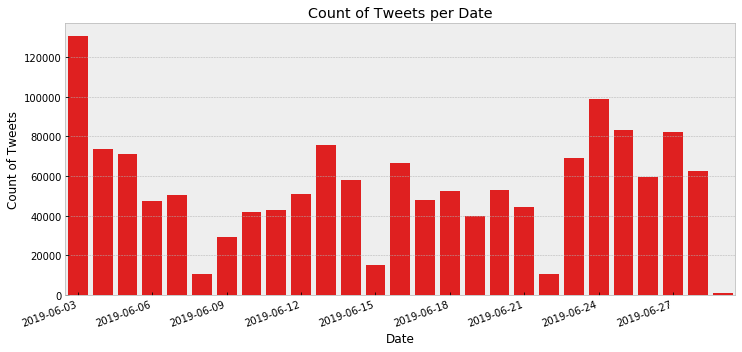

In [58]:
to_plot = get_counts(df, ["date"]) 

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("date", "count", data=to_plot, color="Red", ax=ax1)

format_xticks(to_plot, ax1, 3)
plt.xlabel("Date")
plt.ylabel("Count of Tweets")
plt.title("Count of Tweets per Date");

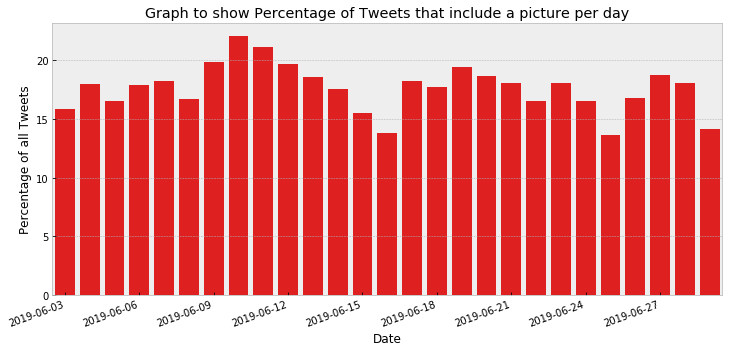

In [59]:
to_plot = get_counts(df, ["date", "pic"]) 
to_plot["perc"] = to_plot.groupby("date")["count"].apply(lambda x: x*100 / x.sum())
to_plot = to_plot[to_plot["pic"] == "yes"]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("date", "perc", data=to_plot, color="Red", ax=ax1)

format_xticks(to_plot, ax1, 3)
plt.title("Graph to show Percentage of Tweets that include a picture per day")
plt.xlabel("Date")
plt.ylabel("Percentage of all Tweets");

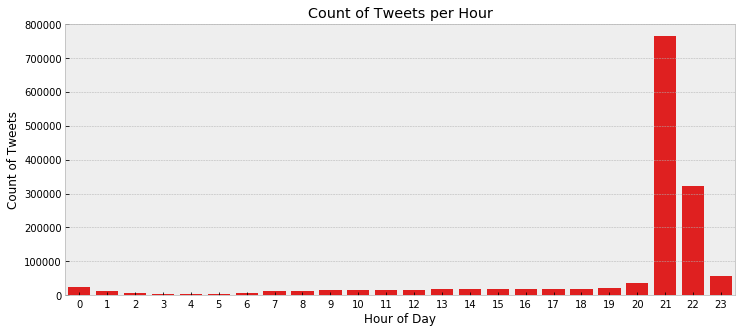

In [60]:
to_plot = get_counts(df, ["hour"]) 

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(111)
sns.barplot("hour", "count", data=to_plot, color="Red", ax=ax1)

plt.xlabel("Hour of Day")
plt.ylabel("Count of Tweets")
plt.title("Count of Tweets per Hour");

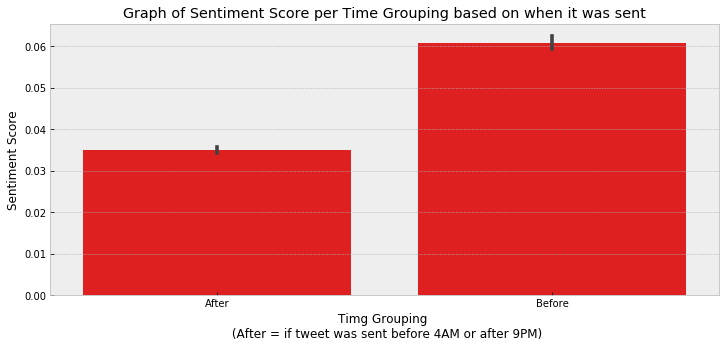

In [61]:
def group_hour(df, col="hour"):
    df["time_group"] = np.where((df[col] < 4) | (df[col] >= 21), "After", "Before")
    return df

df = group_hour(df)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("time_group", "score", data=df, color="Red", ax=ax1)

plt.xlabel("Timg Grouping \n (After = if tweet was sent before 4AM or after 9PM)")
plt.ylabel("Sentiment Score")
plt.title("Graph of Sentiment Score per Time Grouping based on when it was sent");

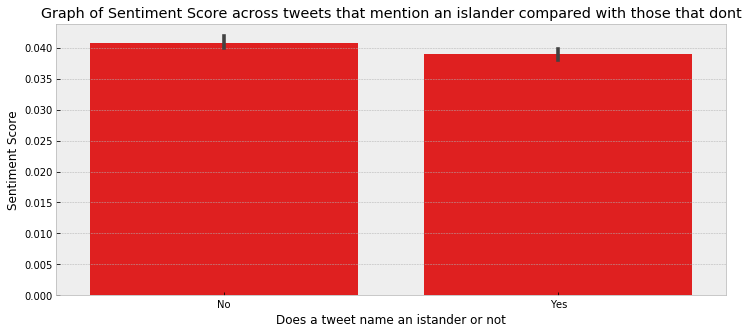

In [62]:
def inc_islander(df, col="islanders"):
    df["inc_islander"] = np.where(df[col].str.len() < 3, "No", "Yes")
    return df

df = inc_islander(df)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("inc_islander", "score", data=df, color="Red", ax=ax1)

plt.xlabel("Does a tweet name an istander or not")
plt.ylabel("Sentiment Score")
plt.title("Graph of Sentiment Score across tweets that mention an islander compared with those that dont");

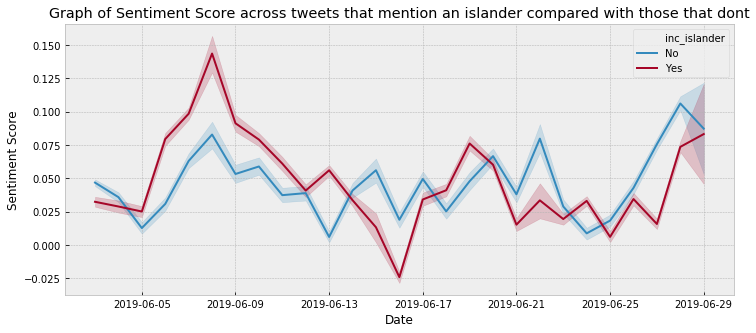

In [63]:
def inc_islander(df, col="islanders"):
    df["inc_islander"] = np.where(df[col].str.len() < 3, "No", "Yes")
    return df

df = inc_islander(df)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.lineplot("date", "score", "inc_islander", data=df, ax=ax1)

plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.title("Graph of Sentiment Score across tweets that mention an islander compared with those that dont");

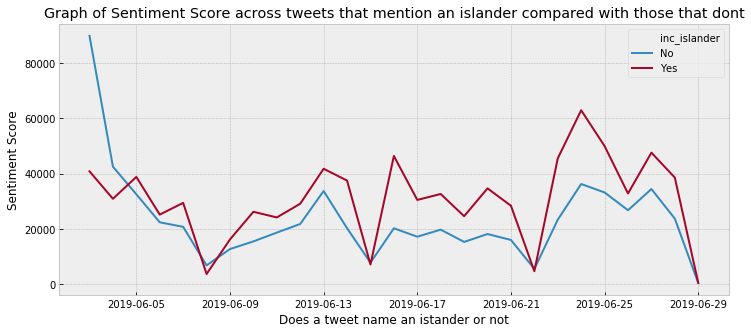

In [64]:
def inc_islander(df, col="islanders"):
    df["inc_islander"] = np.where(df[col].str.len() < 3, "No", "Yes")
    return get_counts(df, ["date", "inc_islander"]) 

to_plot = inc_islander(df)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.lineplot("date", "count", "inc_islander", data=to_plot, ax=ax1)

plt.xlabel("Does a tweet name an istander or not")
plt.ylabel("Sentiment Score")
plt.title("Graph of Sentiment Score across tweets that mention an islander compared with those that dont");

In [89]:
def islander_agg_user(df, islander):
    """Aggregate various metrics per islander/date"""
    AGG_JS = {
        "favs": "sum",
        "retwe": "sum",
        "score": "mean",
        "url": "count",
        "weight_senti": "mean",
    }
    RN_JS = {islander: "islander", "url": "n_tweets"}
    df = df[df[islander] == islander]
    if len(df) > 0:
        return df.groupby(["user", islander])\
                 .agg(AGG_JS)\
                 .reset_index()\
                 .rename(columns=RN_JS)
    return pd.DataFrame()

def aggregate_users(df):
    """Loop over all islanders, aggregating metrics"""
    agg_df = pd.DataFrame()
    for islander in ISLANDERS:
        agg = islander_agg_user(df, islander)
        agg_df = agg_df.append(agg, sort=True)
    return agg_df.sort_values(by="n_tweets", ascending=False)\
                 .reset_index(drop=True)

In [125]:
fav_df = aggregate_users(df)
fav_df = fav_df[fav_df["islander"].isin(RELEVANT_ISLANDERS)]
fav_df = add_cols(fav_df)
fav_df.head()

,favs,islander,n_tweets,retwe,score,user,weight_senti,total_favs,total_retwe,sex
0,521,tommy,308,74,-0.158295,Daily_Star,-0.162913,160468,22792,male
1,446,maura,248,66,-0.062953,Daily_Star,-0.069148,110608,16368,female
2,575,maura,243,164,-0.174688,MirrorTV,-0.566276,139725,39852,female
3,498,tommy,236,173,-0.217614,MirrorTV,-0.511287,117528,40828,male
4,457,lucie,224,156,-0.196153,MirrorTV,-0.489839,102368,34944,female


In [126]:
fav_df_pop = fav_df.sort_values(by="n_tweets", ascending=False).groupby(["islander"]).head(1)
fav_df_pop

,favs,islander,n_tweets,retwe,score,user,weight_senti,total_favs,total_retwe,sex
0,521,tommy,308,74,-0.158295,Daily_Star,-0.162913,160468,22792,male
1,446,maura,248,66,-0.062953,Daily_Star,-0.069148,110608,16368,female
4,457,lucie,224,156,-0.196153,MirrorTV,-0.489839,102368,34944,female
6,707,molly,217,162,-0.223324,MirrorTV,-1.482142,153419,35154,female
9,725,danny,193,175,-0.234590,MirrorTV,-1.412257,139925,33775,male
10,850,amy,184,193,-0.084250,MirrorTV,-0.881955,156400,35512,female
11,508,curtis,176,164,-0.085662,MirrorTV,-0.330411,89408,28864,male
13,31646,yewande,174,5198,0.030563,lovefromtey,-97.553593,5506404,904452,female
44,399,anton,94,75,-0.188305,MirrorTV,-1.514804,37506,7050,male
46,15636,amber,93,2503,0.095341,lovefromtey,124.368890,1454148,232779,female


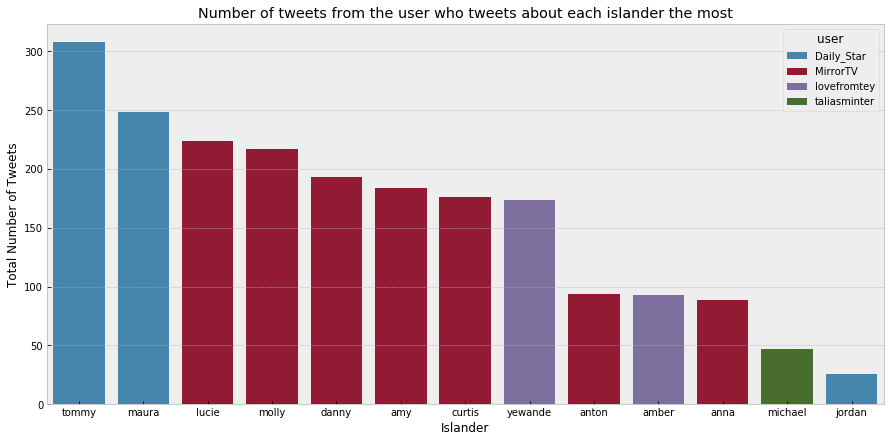

In [127]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(111)

sns.barplot("islander", "n_tweets", "user", data=fav_df_pop, dodge=False, ax=ax1)

plt.xlabel("Islander")
plt.ylabel("Total Number of Tweets")
plt.title("Number of tweets from the user who tweets about each islander the most");

In [128]:
fav_df_pop = fav_df.copy()

fav_df_pop = fav_df_pop[fav_df_pop["n_tweets"] > 20]
fav_df_pop["pos_neg"] = np.where(fav_df_pop["weight_senti"] < 0, "neg", "pos")
fav_df_pop["weight_senti"] = abs(fav_df_pop["weight_senti"])
fav_df_pop = fav_df_pop.sort_values(by="weight_senti", ascending=False).groupby(["islander", "pos_neg"]).head(1)
fav_df_pop

,favs,islander,n_tweets,retwe,score,user,weight_senti,total_favs,total_retwe,sex,pos_neg
1974,237134,michael,24,26683,0.225792,LoveIsland,4530.702621,5691216,640392,male,pos
1458,70171,curtis,28,7423,0.235971,IslandofLove32,1459.482725,1964788,207844,male,pos
1373,70439,amber,28,7450,0.069207,IslandofLove32,1451.991139,1972292,208600,female,pos
1228,90281,yewande,29,11964,0.093055,LoveIsIandUK,1281.900290,2618149,346956,female,pos
926,70214,amy,33,7428,0.148952,IslandofLove32,1238.819727,2317062,245124,female,pos
2801,49751,maura,21,4022,0.170710,ryruckledge,1136.238914,1044771,84462,female,neg
2726,135382,lucie,21,8779,0.173214,LoveIsland,1081.843786,2843022,184359,female,pos
677,63761,anton,36,2797,0.229211,JakeQuickenden,978.982478,2295396,100692,male,pos
406,181857,tommy,42,13431,0.193931,LoveIsland,911.896531,7637994,564102,male,pos
1964,30223,yewande,24,3715,-0.052700,Jonny_Dodds,738.421975,725352,89160,female,neg


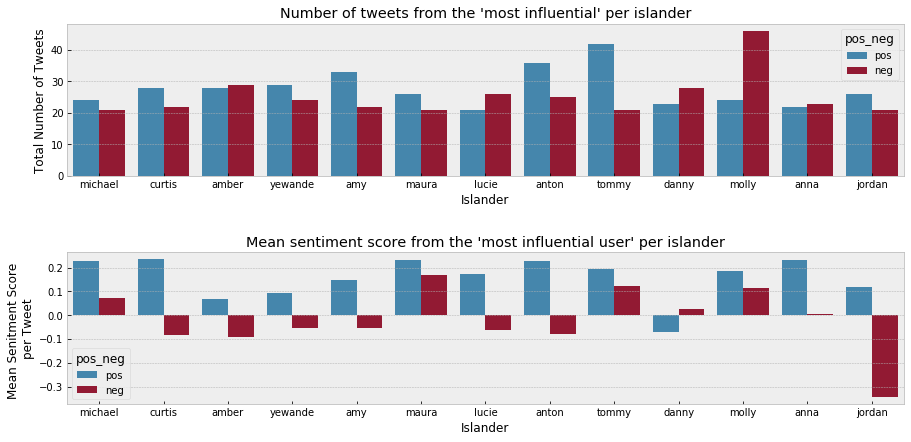

In [133]:
fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(211)
sns.barplot("islander", "n_tweets", "pos_neg", data=fav_df_pop, dodge=True, ax=ax1)
ax1.set_xlabel("Islander")
ax1.set_ylabel("Total Number of Tweets")
ax1.set_title("Number of tweets from the 'most influential' per islander")

ax2 = fig.add_subplot(212)
sns.barplot("islander", "score", "pos_neg", data=fav_df_pop, dodge=True, ax=ax2)
ax2.set_xlabel("Islander")
ax2.set_ylabel("Mean Senitment Score \nper Tweet")
ax2.set_title("Mean sentiment score from the 'most influential user' per islander")

plt.subplots_adjust(hspace=0.5);

In [130]:
favs = df.groupby(["user", "date"])\
         .agg({"favs":"sum", "url": "count"})\
         .reset_index()\
         .rename(columns={"url": "n_tweets"})

favs["rate"] = favs["favs"] / favs["n_tweets"]
days = favs.groupby("user").size().reset_index(name="n_days")
favs = favs.merge(days, on="user", how="left")
favs.head()

,user,date,favs,n_tweets,rate,n_days
0,00000TomCooper,2019-06-23,8,1,8.0,1
1,000_wilson,2019-06-04,3,1,3.0,1
2,001Randomess95,2019-06-03,2,2,1.0,7
3,001Randomess95,2019-06-06,6,1,6.0,7
4,001Randomess95,2019-06-11,0,1,0.0,7


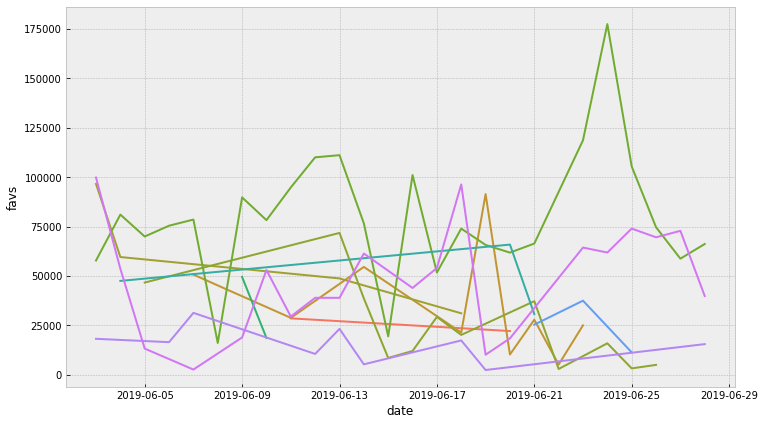

In [131]:
favs_t = favs[(favs["rate"] > 2000) & (favs["n_days"] > 20)]
len(favs)
# favs.sort_values("rate", ascending=False).head()


fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(111)
sns.lineplot("date", "favs", "user", data=favs_t, ax=ax1)
plt.legend().remove()

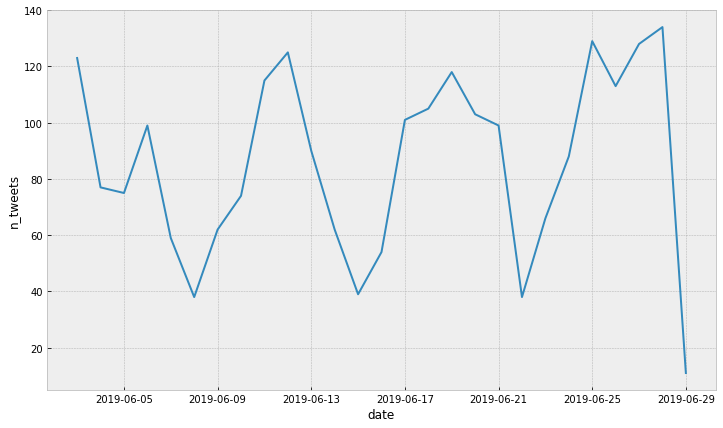

In [132]:
favs_t = favs.sort_values("n_tweets", ascending=False).groupby("date").head(1)

fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(111)
sns.lineplot("date", "n_tweets", data=favs_t, ax=ax1)